## Imports

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
import os

## Generator

In [9]:
class Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, output_shape):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(label_dim, label_dim)
        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, int(np.prod(output_shape))),
            nn.Tanh()
        )
        self.output_shape = output_shape

    def forward(self, noise, labels):
        label_input = self.label_embedding(labels)
        x = torch.cat((noise, label_input), dim=1)
        output = self.model(x)
        return output.view(-1, *self.output_shape)


## Critic

In [ ]:
class Critic(nn.Module):
    def __init__(self, input_shape, label_dim) -> None:
        super(Critic, self).__init__()
        self.label_embedding = nn.Embedding(label_dim, label_dim)
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(input_shape)) + label_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, data, labels):
        label_input = self.label_embedding(labels)
        x = torch.cat((data.view(data.size(0), -1), label_input), dim=1)
        return self.model(x)

## Gradient penalty

In [6]:
def gradient_penalty(critic, real_data, fake_data, labels, device):
    batch_size, *_ = real_data.size()
    
    alpha = torch.rand(batch_size, 1).to(device)

    alpha = alpha.expand(real_data.size())
    
    interpolated = (alpha * real_data + (1 - alpha) * fake_data).requires_grad_(True)

    # Pass the interpolated data and labels to the critic:
    critic_interpolates = critic(interpolated, labels)

    # Calculate gradients:
    gradients = grad(
        outputs=critic_interpolates,
        inputs=interpolated,
        grad_outputs=torch.ones_like(critic_interpolates).to(device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Reshape gradients and calculate gradient penalty:
    gradients = gradients.view(gradients.size(0), -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

## Model hyperparameters

In [ ]:
noise_dim = 100  # Dimension of noise vector
label_dim = 8  # Number of classes for conditional labels
output_shape = (50, 30)
lr = 1e-4  # Learning rate
lambda_gp = 10  # Gradient penalty weight
batch_size = 64  
epochs = 20000
critic_steps = 5

## Initialization

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = Generator(noise_dim, label_dim, output_shape).to(device)
critic = Critic(output_shape, label_dim).to(device)

In [9]:
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_C = optim.Adam(critic.parameters(), lr=lr, betas=(0.5, 0.9))

## Data preprocessing

In [ ]:
data_csi = torch.load('data_mm_user1.pth')
labels = torch.load('labels_user1.pth')

min_val = data_csi.min()
max_val = data_csi.max()

data_csi = 2 * ((data_csi - min_val) / (max_val - min_val)) - 1


data_csi = data_csi.float()
labels = labels.float()

dataset = TensorDataset(data_csi, labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Training

Epoch [0/20000] | Critic Loss: -3.0393 | Generator Loss: 2.7533
Epoch [1/20000] | Critic Loss: -2.9437 | Generator Loss: 2.7398
Epoch [2/20000] | Critic Loss: -2.9132 | Generator Loss: 2.8221
Epoch [3/20000] | Critic Loss: -2.9228 | Generator Loss: 2.9362
Epoch [4/20000] | Critic Loss: -2.9780 | Generator Loss: 2.7425
Epoch [5/20000] | Critic Loss: -2.9464 | Generator Loss: 2.9194
Epoch [6/20000] | Critic Loss: -2.9194 | Generator Loss: 2.7046
Epoch [7/20000] | Critic Loss: -2.9578 | Generator Loss: 3.0955
Epoch [8/20000] | Critic Loss: -2.8573 | Generator Loss: 2.8530
Epoch [9/20000] | Critic Loss: -3.0175 | Generator Loss: 2.6720
Epoch [10/20000] | Critic Loss: -2.9137 | Generator Loss: 2.8230
Epoch [11/20000] | Critic Loss: -2.9648 | Generator Loss: 2.8619
Epoch [12/20000] | Critic Loss: -3.0436 | Generator Loss: 3.1063
Epoch [13/20000] | Critic Loss: -2.9900 | Generator Loss: 3.0060
Epoch [14/20000] | Critic Loss: -3.0026 | Generator Loss: 2.8549
Epoch [15/20000] | Critic Loss: -2.

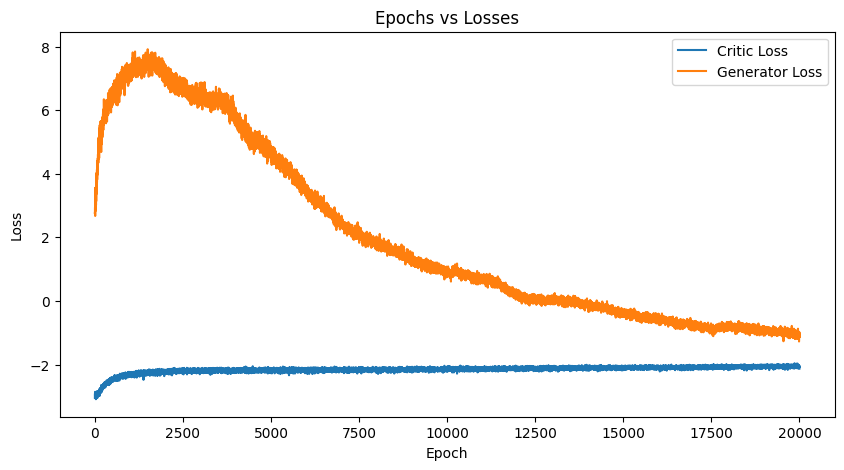

In [ ]:
g_losses = []  # Generator losses
c_losses = []  # Critic losses

# Training loop
for epoch in range(epochs):
    epoch_c_loss = 0  
    epoch_g_loss = 0  

    for real_data, labels_batch in dataloader:
        
        real_data, labels_batch = real_data.to(device), labels_batch.to(device)
        labels_batch = labels_batch.long()  # Ensure the labels are integers for embedding
        
        current_batch_size = real_data.shape[0]

        real_data = real_data.view(current_batch_size, -1)  # Flatten to (current_batch_size, 1500) for (50, 30)

        # Train Critic
        for _ in range(critic_steps):
            
            noise = torch.randn(current_batch_size, noise_dim).to(device)
            fake_data = generator(noise, labels_batch)
            fake_data = fake_data.view(current_batch_size, -1)  # Flatten fake data to match real_data shape

            # Critic loss with gradient penalty
            critic_real = critic(real_data, labels_batch)
            critic_fake = critic(fake_data.detach(), labels_batch)

            gp = gradient_penalty(critic, real_data, fake_data, labels_batch, device)  
            critic_loss = -(torch.mean(critic_real) - torch.mean(critic_fake)) + lambda_gp * gp

            optimizer_C.zero_grad()
            critic_loss.backward()
            optimizer_C.step()

        # Train Generator
        noise = torch.randn(current_batch_size, noise_dim).to(device)
        fake_data = generator(noise, labels_batch)
        fake_data = fake_data.view(current_batch_size, -1)  # Flatten the fake data for critic

        generator_loss = -torch.mean(critic(fake_data, labels_batch))

        optimizer_G.zero_grad()
        generator_loss.backward()
        optimizer_G.step()

        
        epoch_c_loss += critic_loss.item()
        epoch_g_loss += generator_loss.item()

    
    avg_c_loss = epoch_c_loss / len(dataloader)
    avg_g_loss = epoch_g_loss / len(dataloader)

    
    c_losses.append(avg_c_loss)
    g_losses.append(avg_g_loss)

    
    print(f"Epoch [{epoch}/{epochs}] | Critic Loss: {avg_c_loss:.4f} | Generator Loss: {avg_g_loss:.4f}")
    
    if (epoch + 1) % 1000 == 0:
        with torch.no_grad():
            noise = torch.randn(25, noise_dim).to(device)
            sample_labels = torch.randint(0, label_dim, (25,)).to(device)
            generated_samples = generator(noise, sample_labels)
            save_dir = 'cwgan_logs_mid_training'
            os.makedirs(save_dir, exist_ok=True)
            
            
            torch.save(generated_samples, os.path.join(save_dir, f'samples_epoch_{epoch+1}.pth'))
            torch.save(sample_labels, os.path.join(save_dir, f'labels_epoch_{epoch+1}.pth'))
            torch.save(generator.state_dict(), os.path.join(save_dir, f'generator_epoch_{epoch+1}.pth'))
            
            loss_info = f"Epoch [{epoch+1}/{epochs}] | Critic Loss: {avg_c_loss:.4f} | Generator Loss: {avg_g_loss:.4f}"
        
            # Save loss information to a text file
            with open(os.path.join(save_dir, 'training_losses.txt'), 'a') as f:
                f.write(loss_info + '\n')
            print(f"Saved generated samples, labels, generator state, and loss info at epoch {epoch+1}")


plt.figure(figsize=(10, 5))
plt.plot(range(epochs), c_losses, label='Critic Loss')
plt.plot(range(epochs), g_losses, label='Generator Loss')
plt.title('Epochs vs Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join('cwgan_logs_mid_training', 'loss_cwgan_gp.png'))
plt.show()


In [22]:
def generate_balanced_samples(generator, num_samples_per_class, num_classes=8, save_folder='cwgan_generated_samples'):
    generator.eval()
    os.makedirs(save_folder, exist_ok=True)
    
    total_synthetic_data = []
    total_synthetic_labels = []
    
    with torch.no_grad(): 
        for class_id in range(num_classes):
            noise =  torch.randn(num_samples_per_class, 100).to(device)
            labels = torch.full((num_samples_per_class,), class_id, device=device, dtype=torch.long) 
            #labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()  

            # Generate synthetic data
            synthetic_data = generator(noise, labels).detach().cpu()
            synthetic_labels = labels.cpu()
            
            total_synthetic_data.append(synthetic_data)
            total_synthetic_labels.append(synthetic_labels)

    # Concatenate all class samples
    total_synthetic_data = torch.cat(total_synthetic_data, dim=0)
    total_synthetic_labels = torch.cat(total_synthetic_labels, dim=0)
    
    torch.save(total_synthetic_data, os.path.join(save_folder, 'CWGAN_GP_data.pth'))
    torch.save(total_synthetic_labels, os.path.join(save_folder, 'CWGAN_GP_labels.pth'))
    
    print(f'Saved {num_classes * num_samples_per_class} synthetic samples with equal class distribution in {save_folder}')
    
    return total_synthetic_data, total_synthetic_labels

synthetic_data, synthetic_labels = generate_balanced_samples(generator, num_samples_per_class=200)


Saved 1600 synthetic samples with equal class distribution in cwgan_generated_samples
